<a href="https://colab.research.google.com/github/Shi-raishi/Research/blob/main/nutr_ratio__all_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ③②の変数をE_CR～E_SSまでの和で除した１７食品群別エネルギー摂取比率<br>
## 補正なし<br>
穀類E_CR			いも類E_PT					砂糖・甘味料類E_SG		豆類E_PL
緑黄色野菜E_GV	その他の野菜*E_OV		果実類E_FR						魚介類E_FS
肉類E_MT			卵類E_EG					乳類E_MK						油脂類E_OL
菓子類E_SW		嗜好飲料類E_BR			調味料・香辛料類E_SS


In [27]:
# Google Colabにlingamのライブラリをインストールする
# !pip install numpy
# !pip install numpy==1.24.3
!pip install numpy
!pip install lingam

In [28]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import print_causal_directions, print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.2', '1.5.3', '0.20.1', '1.8.2']


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
%cd /content/drive/MyDrive/'Colab Notebooks'
%ls CSV

/content/drive/MyDrive/Colab Notebooks
'BDHQ フォーマット LongDataSet (f_nutr1).csv'
'BDHQ フォーマット LongDataSet (nutr).csv'
'BDHQ フォーマット LongDataSet (signal).csv'
'BDHQ 児童生徒用フォーマット LongDataSet (food2).csv'
'BDHQ 成人用フォーマット LongDataSet (food).csv'
 Shift-JISに変換したもの/


### 関数定義

In [31]:
# 変数同士の相関を確認
def corrMatrix(df):
  # 相関行列の作成
  corr_matrix = df.corr()

  # 高い相関を持つ変数ペアの抽出
  threshold = 0.5  # 閾値を設定
  high_corr_var = [(column, index, corr_matrix[column][index]) for column in corr_matrix.columns for index in corr_matrix.columns if (corr_matrix[column][index] > threshold) & (column != index)]
  for var_pair in high_corr_var:
      print(var_pair)

In [32]:
# # 特定の変数と他の変数との相関を確認
# def targetCorrMatrix(df):
#   df = 'VEG3'
#   correlations = values_dataframe.corrwith(values_dataframe[df])
#   correlations.sort_values(ascending=False)

In [33]:
# ヒートマップで相関関係の可視化
def heatMap(df):
  plt.figure(figsize=(15, 15))
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
  plt.show()

In [34]:
# 個々の変数の分布を確認
def distribution(df):
  for column in df.columns:
      plt.figure()
      sns.histplot(df[column], kde=True)
      plt.title(column)
      plt.show()

In [35]:
# 変数の0データを確認
def countZeroData(df):
  # 各変数における0の数をカウントし、少ない順にソート
  zero_counts_sorted = (df == 0).sum().sort_values()
  # 各変数における0データ数の表示
  print(zero_counts_sorted)

In [36]:
# 0データの数をグラフで確認
def countAvairableVariable(df):
  # 0が含まれる数をカウント
  zero_counts = (df == 0).sum().sort_values()

  # グラフのサイズを設定
  plt.figure(figsize=(12, 9))

  # 棒グラフの作成
  sns.barplot(x=len(df)-zero_counts.values, y=zero_counts.index)

  # グラフのタイトルとラベルを設定
  plt.title('Number of non-zero data in each variable')
  plt.xlabel('number of non-zero data')
  plt.ylabel('variable name')

  # グラフの表示
  plt.show()

In [37]:
def checksVariables(df):
  # # non-zeroのデータ数を確認
  # countZeroData(df)
  # non-zeroのデータ数をグラフで確認
  countAvairableVariable(df)
  # 相関行列を確認
  corrMatrix(df)
  # ヒートマップ確認
  heatMap(df)
  # 各変数の分布を確認
  # distribution(df)

### データ前処理

In [38]:
# CSVの読み込み
data_nutr = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (nutr).csv')
data_fnutr1 = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (f_nutr1).csv')

In [39]:
print(len(data_nutr),len(data_fnutr1))

3329 3347


## ↓idの重複削除、結合

In [40]:
# data_fnutr1重複を確認
print("data_fnutr1 で重複のある行数:", data_fnutr1['ID1'].duplicated(keep=False).sum())

# data_nutr重複を確認
print("data_nutr で重複のある行数:", data_nutr['ID1'].duplicated(keep=False).sum())


data_fnutr1 で重複のある行数: 136
data_nutr で重複のある行数: 116


In [41]:
# data_nutrから重複を除去
data_nutr_cleaned = data_nutr.drop_duplicates(subset='ID1', keep=False)
print(len(data_nutr_cleaned))

3213


In [42]:
# 左結合
merged_data = pd.merge(data_fnutr1, data_nutr_cleaned, on='ID1', how='left')
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3347 entries, 0 to 3346
Columns: 352 entries, ID1 to filename_y
dtypes: float64(322), int64(26), object(4)
memory usage: 9.0+ MB
None


In [43]:
# 結合後のデータフレームのIDの重複を確認
merged_data['ID1'].duplicated(keep=False).sum()

136

In [44]:
# 結合後のデータフレームのIDの重複を削除
cleaned_data = merged_data.drop_duplicates(subset='ID1',keep=False)# 重複の確認
print(cleaned_data['ID1'].duplicated().sum())
print(len(cleaned_data))

0
3211


In [45]:
print(cleaned_data.info())
print(len(cleaned_data))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3211 entries, 0 to 3302
Columns: 352 entries, ID1 to filename_y
dtypes: float64(322), int64(26), object(4)
memory usage: 8.6+ MB
None
3211


### ↓変数作成


In [50]:
## 17食品群合計エネルギー摂取量とBMIを作成
# cleaned_dataのコピーを作成（SettingWithCopyWarningというエラーが出るため）
cleaned_data_copy = cleaned_data.copy()

# 新しい列を追加
cleaned_data_copy['BMI'] = cleaned_data_copy['BW'] / ((cleaned_data_copy['BH'] / 100) ** 2)
cleaned_data_copy['total_intake'] = cleaned_data_copy.loc[:, 'E_CR':'E_SS'].sum(axis=1)

# 結果を表示
cleaned_data_copy.head(1)

,ID1,ID2_x,ID3_x,W_CR,W_PT,W_SG,W_PL,W_GV,W_OV,W_FR,...,C15SA,C16SI,C17SA,C162,C164,C215N3,C224N6,filename_y,BMI,total_intake
0,201100005,2015.0,11,303.195981,27.717256,8.135054,144.377205,145.014042,111.979363,268.098456,...,66.705377,33.840735,68.422717,12.778114,11.422267,10.633959,6.529471,012（会津若松市）全市成人_BDHQ2012_623件【結合】151013_3,22.340297,2192.890371


       E_CR      E_PT      E_SG      E_PL      E_GV      E_OV      E_FR  \
0  0.278666  0.010757  0.014245  0.049914  0.017423  0.010306  0.050179   

       E_FS      E_MT      E_EG      E_MK      E_OL      E_SW      E_BR  \
0  0.067337  0.062115  0.022494  0.161922  0.048367  0.101427  0.054498   

       E_SS  
0  0.050349  


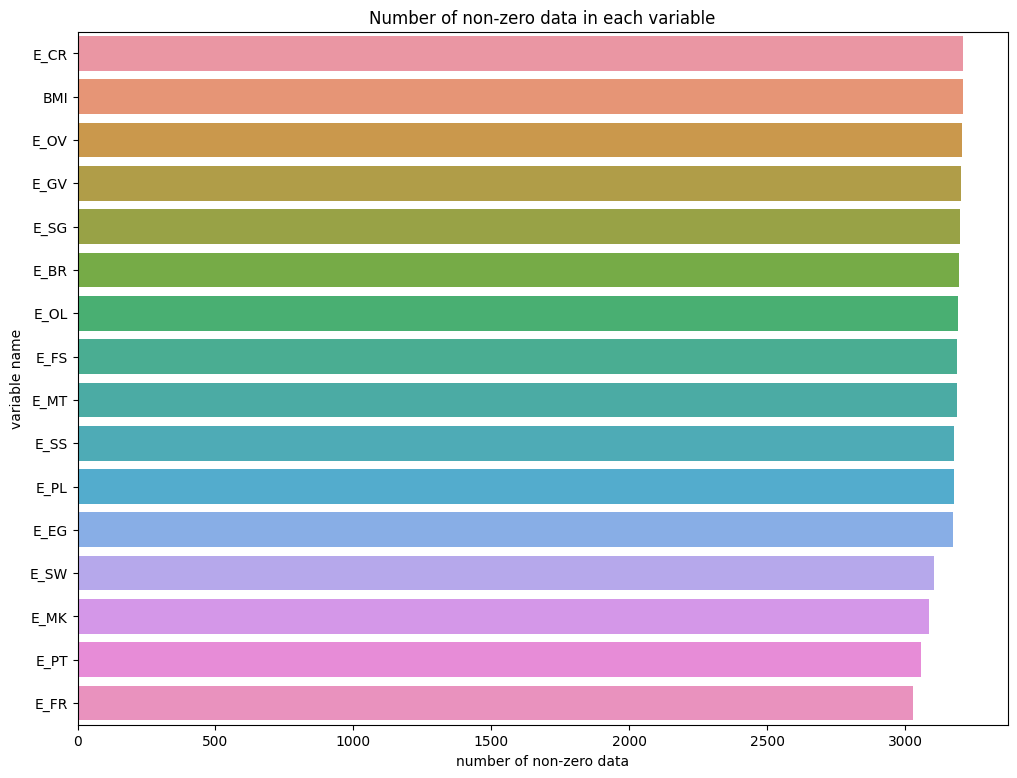

('E_GV', 'E_OV', 0.6218306210216428)
('E_OV', 'E_GV', 0.6218306210216428)


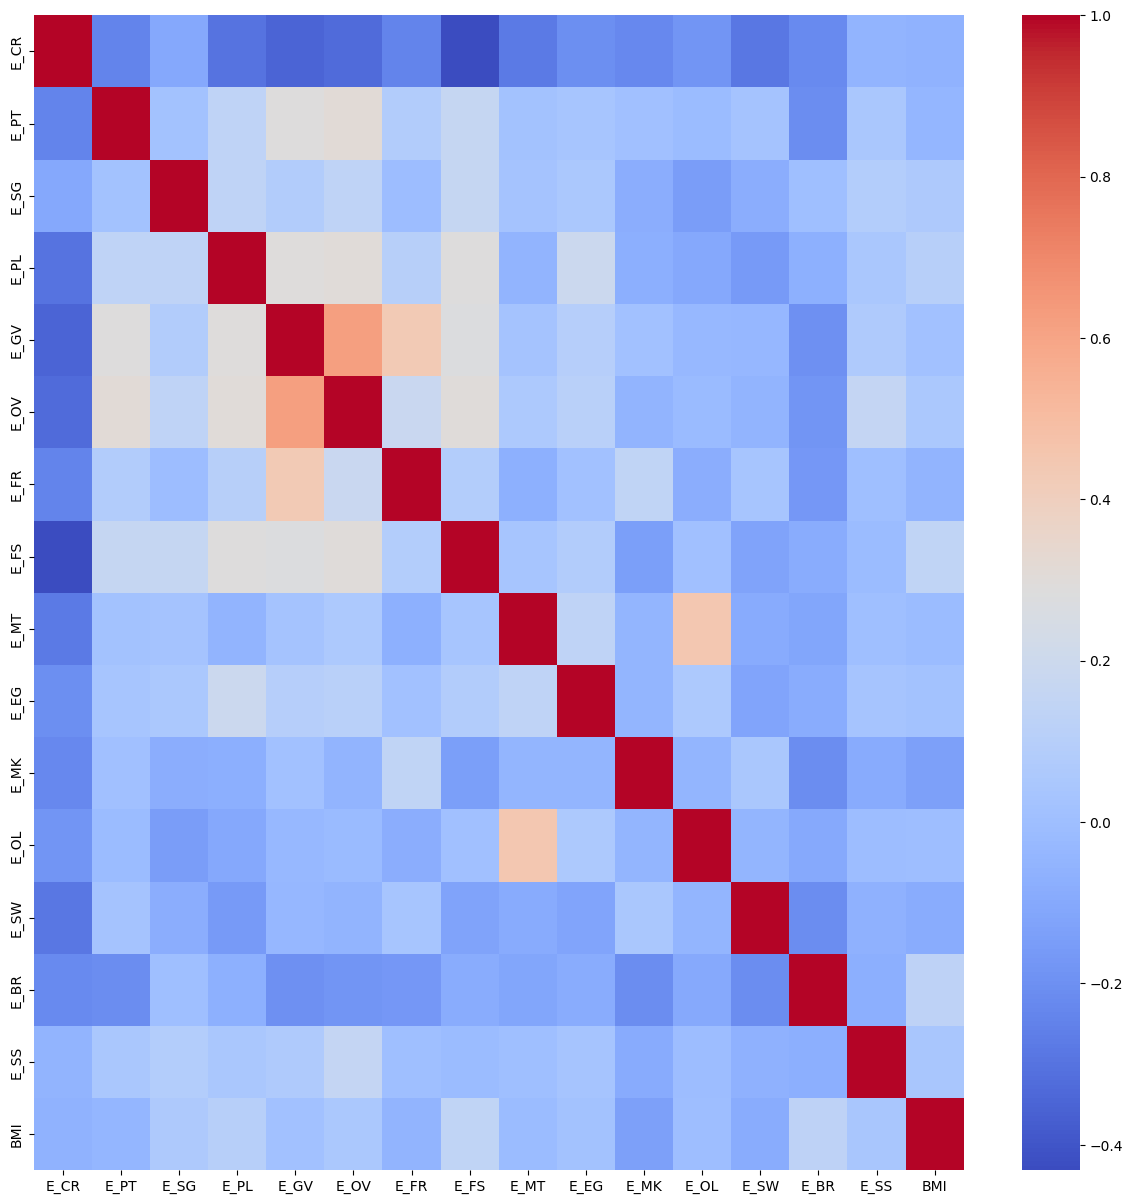

In [102]:
# 変数選択
values_dataframe = cleaned_data_copy.loc[:, 'E_CR':'E_SS'].copy()
values_dataframe['total_intake'] = cleaned_data_copy['total_intake']
# 合計摂取量で割る
values_dataframe = values_dataframe.drop(['total_intake'],axis=1).div(values_dataframe['total_intake'], axis=0)
print(values_dataframe.head(1))
# データ数と相関の確認
values_dataframe['BMI'] = cleaned_data_copy['BMI']
checksVariables(values_dataframe)

In [103]:
# 変数追加
values_dataframe['AGE'] = cleaned_data_copy['AGE']
values_dataframe['SEX'] = cleaned_data_copy['SEX']

In [104]:
# NA処理
values_dataframe_cleaned = values_dataframe.dropna()

### LiNGAMの関数定義

In [105]:
# 解析に使用する変数の選択（）
def select(df):
    # 基本統計量の確認
    df.describe()

    # 各列について、上:0.5%,下:0.5%のデータを外れ値として除去
    for column in df.columns:
        lower_limit = df[column].quantile(0.005)
        upper_limit = df[column].quantile(0.995)
        df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    # 修正されたデータフレームを表示
    df.describe()

    len(df)

    return df

In [106]:
def modeling(selected_columns):
  # 標準化
  scaler = StandardScaler()
  Xy = scaler.fit_transform(selected_columns)

  # モデル作成
  model = lingam.DirectLiNGAM(random_state=1)
  model.fit(Xy)

  # 因果の順番
  print(f"因果の順番\n{model.causal_order_}\n\n")

  # 隣接行列
  print(f"隣接行列\n{model.adjacency_matrix_}\n\n")

  # 推定した因果モデルにおける、誤差同士の独立性のp値
  p_values = model.get_error_independence_p_values(Xy)
  print(f"推定した因果モデルにおける、誤差同士の独立性のp値\n{p_values}\n\n")

  return model

In [140]:
def gragh(model, selected_columns,dagname):
    # 因果グラフの描画
    dot = make_dot(model.adjacency_matrix_, labels=selected_columns.columns.to_list())
    dot.format = 'png'
    dot.render(dagname)
    return dot

In [108]:
def lingam_matrix(df):
    scaler = StandardScaler()
    Xy = scaler.fit_transform(df)

    model = lingam.DirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy, n_sampling=100)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
    cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_causal_directions(cdc, 100, labels=df.columns.to_list())

    # カウント結果を確率として、隣接行列の形式で表示
    prob = result.get_probabilities(min_causal_effect=0.01)
    print(prob)

    # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
    dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_dagc(dagc, 100, labels=df.columns.to_list())

    # Total Causal Effects
    causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

    # Assign to pandas.DataFrame for pretty display
    causal_df = pd.DataFrame(causal_effects)
    labels = df.columns.to_list()
    # 'from' 列と 'to' 列のラベルを適用する
    causal_df['from'] = causal_df['from'].apply(lambda x: labels[x])
    causal_df['to'] = causal_df['to'].apply(lambda x: labels[x])
    return causal_df

In [109]:
def LiNGAM(df,dagname):
  selected_columns = select(df)
  model = modeling(selected_columns)
  dot = gragh(model, selected_columns,dagname)
  re_df = lingam_matrix(selected_columns)
  return dot,re_df

In [110]:
print(values_dataframe_cleaned.columns.tolist())

['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_OV', 'E_FR', 'E_FS', 'E_MT', 'E_EG', 'E_MK', 'E_OL', 'E_SW', 'E_BR', 'E_SS', 'BMI', 'AGE', 'SEX']


In [111]:
# 変数を指定するリスト
selected_variables = ['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_OV', 'E_FR', 'E_FS', 'E_MT', 'E_EG', 'E_MK', 'E_OL', 'E_SW', 'E_BR', 'E_SS', 'BMI']

# 使用する変数を確認
df = values_dataframe_cleaned[selected_variables]
df

,E_CR,E_PT,E_SG,E_PL,E_GV,E_OV,E_FR,E_FS,E_MT,E_EG,E_MK,E_OL,E_SW,E_BR,E_SS,BMI
0,0.278666,0.010757,0.014245,0.049914,0.017423,0.010306,0.050179,0.067337,0.062115,0.022494,0.161922,0.048367,0.101427,0.054498,0.050349,22.340297
1,0.373219,0.039828,0.006189,0.028121,0.008643,0.021043,0.004932,0.025475,0.066909,0.033315,0.146727,0.060703,0.096427,0.041203,0.047265,29.384757
2,0.474831,0.010555,0.008873,0.005858,0.012603,0.016147,0.020070,0.031054,0.056143,0.061800,0.098252,0.057827,0.106532,0.025665,0.013792,19.568236
3,0.445178,0.016390,0.003795,0.003638,0.011011,0.014621,0.000000,0.096996,0.104935,0.038388,0.011996,0.058244,0.109069,0.049913,0.035825,25.854639
4,0.313361,0.037599,0.009220,0.016114,0.014448,0.013594,0.032373,0.168024,0.078076,0.044030,0.069240,0.057127,0.072484,0.033694,0.040616,23.214198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,0.522715,0.011195,0.000062,0.040688,0.001040,0.000000,0.005450,0.012201,0.053710,0.064112,0.246516,0.004822,0.000000,0.006596,0.030894,15.061332
3297,0.322125,0.021771,0.004134,0.033107,0.014272,0.015262,0.043415,0.034801,0.050030,0.033461,0.158638,0.032521,0.125938,0.089377,0.021149,15.320256
3300,0.473000,0.017586,0.002341,0.005148,0.002701,0.004423,0.003084,0.019425,0.037332,0.011105,0.043070,0.030939,0.129782,0.197808,0.022255,18.668680
3301,0.474578,0.011312,0.003834,0.014581,0.008775,0.008742,0.034574,0.054730,0.056902,0.017913,0.180195,0.048743,0.046847,0.021541,0.016735,19.113632


In [112]:
# 0data削除
df_filtered = df[(df != 0).all(axis=1)]

# 結果を表示
print(df_filtered.describe())

              E_CR         E_PT         E_SG         E_PL         E_GV  \
count  2690.000000  2690.000000  2690.000000  2690.000000  2690.000000   
mean      0.369150     0.027447     0.009694     0.038976     0.017691   
std       0.114239     0.020406     0.007476     0.026986     0.010345   
min       0.054691     0.001531     0.000011     0.001362     0.000326   
25%       0.291856     0.012086     0.004327     0.018047     0.010257   
50%       0.364674     0.023052     0.007893     0.032917     0.015745   
75%       0.442367     0.036242     0.012753     0.054380     0.023067   
max       0.812472     0.170374     0.054120     0.168140     0.074750   

              E_OV         E_FR         E_FS         E_MT         E_EG  \
count  2690.000000  2690.000000  2690.000000  2690.000000  2690.000000   
mean      0.020947     0.025202     0.075304     0.073101     0.033367   
std       0.012073     0.020760     0.049108     0.035470     0.020273   
min       0.000147     0.000937     0

因果の順番
[13, 1, 9, 12, 10, 7, 14, 11, 8, 15, 5, 2, 6, 4, 0, 3]


隣接行列
[[ 0.         -0.18677703 -0.07367333  0.         -0.12210309 -0.14227767
  -0.17940322 -0.47194002 -0.29042917 -0.20070289 -0.46426867 -0.18460021
  -0.57187201 -0.61168069 -0.13693317 -0.01298595]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.         -0.1785529   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.08062861
   0.          0.16033866  0.13759334  0.          0.         -0.27714377
   0.          0.          0.05751065  0.        ]
 [-4.16044789 -0.74545701 -0.27757408  0.         -0.37044866 -0.43251588
  -0.76681562 -1.80068658 -1.27248126 -0.73536452 -1.98503907 -0.86102538
  -2.4897904  -2.56084519 -0.58229064  0.        ]
 [ 0.          0.11996559  0.          0.          0.          0.47499914
   0.30035084  0.08703444  0.          0.          0.          0.
   0.       

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=3.515e-03, previous alpha=2.636e-03, with an active set of 14 regressors.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=8.787e-04, previous alpha=3.295e-04, with an active set of 14 regressors.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=5.272e-03, previous alpha=3.163e-03, with an active set of 14 regressors.
  warnings.warn(
/usr/lo

E_CR <--- E_PT (b<0) (100.0%)
E_SG <--- E_OL (b<0) (100.0%)
BMI <--- E_BR (b>0) (100.0%)
E_FR <--- E_BR (b<0) (100.0%)
E_PT <--- E_BR (b<0) (100.0%)
E_MK <--- E_BR (b<0) (100.0%)
E_SW <--- E_BR (b<0) (100.0%)
E_CR <--- E_SS (b<0) (100.0%)
[[0.   1.   0.94 0.71 0.92 0.94 1.   1.   1.   0.93 0.99 1.   0.99 1.
  1.   0.14]
 [0.   0.   0.   0.02 0.12 0.   0.13 0.47 0.   0.05 0.07 0.   0.02 1.
  0.01 0.09]
 [0.05 0.06 0.   0.17 0.28 0.65 0.32 1.   1.   0.21 0.29 1.   0.25 0.14
  0.6  0.13]
 [0.29 0.83 0.38 0.   0.51 0.45 0.45 0.98 0.47 0.76 0.76 0.76 0.88 0.41
  0.35 0.32]
 [0.08 0.88 0.09 0.49 0.   0.53 1.   0.94 0.32 0.29 0.14 0.11 0.19 0.51
  0.38 0.05]
 [0.06 1.   0.26 0.55 0.47 0.   0.37 0.91 0.72 0.25 0.33 0.2  0.12 0.94
  1.   0.05]
 [0.   0.14 0.16 0.06 0.   0.39 0.   0.71 0.34 0.06 0.73 0.36 0.03 1.
  0.06 0.26]
 [0.   0.52 0.   0.02 0.04 0.09 0.22 0.   0.09 0.07 0.92 0.14 0.81 0.88
  0.19 0.14]
 [0.   0.03 0.   0.18 0.03 0.1  0.23 0.1  0.   0.65 0.58 0.79 0.87 1.
  0.03 0.04]
 [0.

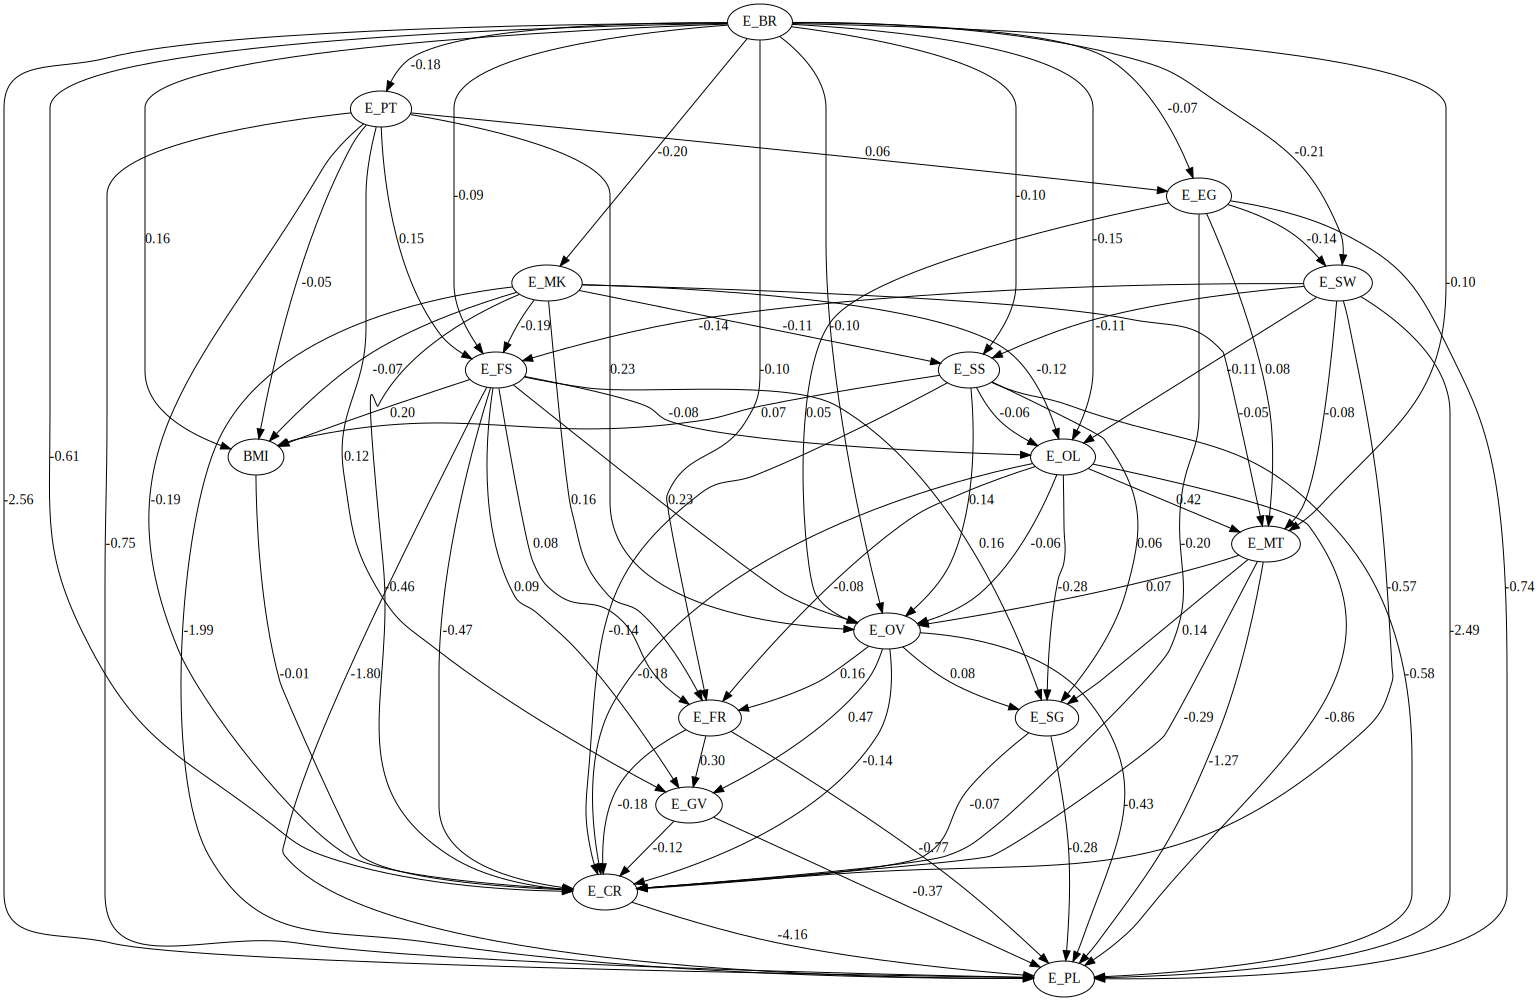

In [113]:
dot,causal_df = LiNGAM(df_filtered,'nutr_ratio_all_data')
dot

In [122]:
causal_df

,from,to,effect,probability
0,E_PT,E_CR,-0.278912,1.00
1,E_BR,BMI,0.164058,1.00
2,E_SS,E_OV,0.146043,1.00
3,E_OL,E_SG,-0.230961,1.00
4,E_BR,E_OV,-0.166745,1.00
...,...,...,...,...
200,BMI,E_OL,-0.058428,0.01
201,E_CR,E_SW,-1.663352,0.01
202,E_FR,E_SW,0.056457,0.01
203,E_OV,E_MK,-0.103758,0.01


## 変数を減らす


In [132]:
print(values_dataframe_cleaned.columns.tolist())

['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_OV', 'E_FR', 'E_FS', 'E_MT', 'E_EG', 'E_MK', 'E_OL', 'E_SW', 'E_BR', 'E_SS', 'BMI', 'AGE', 'SEX']


In [144]:
# 変数を指定するリスト(その他野菜、油脂類、果実類を削除)
selected_variables = ['E_CR', 'E_PT', 'E_GV', 'E_FR', 'E_MT', 'E_SW', 'BMI']
# 使用する変数を確認
df = values_dataframe_cleaned[selected_variables]
# 0data削除
df_filtered = df[(df != 0).all(axis=1)]
# LiNGAM
dot,causal_df = LiNGAM(df_filtered,'nutr_ratio_all_data')
dot

因果の順番
[5, 3, 4, 1, 2, 0, 6]


隣接行列
[[ 0.         -0.1562563  -0.25224231 -0.13971416 -0.26712754 -0.32262813
   0.        ]
 [ 0.          0.          0.          0.07061451  0.          0.
   0.        ]
 [ 0.          0.26397617  0.          0.39541771  0.04533727 -0.05988875
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.         -0.07530296  0.         -0.08369695
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [-0.19475241 -0.07363841  0.         -0.09218879 -0.06792714 -0.14842384
   0.        ]]


推定した因果モデルにおける、誤差同士の独立性のp値
[[0.00000000e+00 9.48558029e-10 5.73934568e-05 4.38167336e-07
  1.11724769e-07 1.83056981e-15 2.74026676e-01]
 [9.48558029e-10 0.00000000e+00 6.28912529e-11 1.37975030e-05
  1.72371860e-09 1.38355221e-11 2.89071499e-04]
 [5.73934568e-05 6.28912529e-11 0.00000000e+00 1.32091329e-07
  1.35354026e-01 1.57779213e-01 5.87613367e-05]
 [4.381

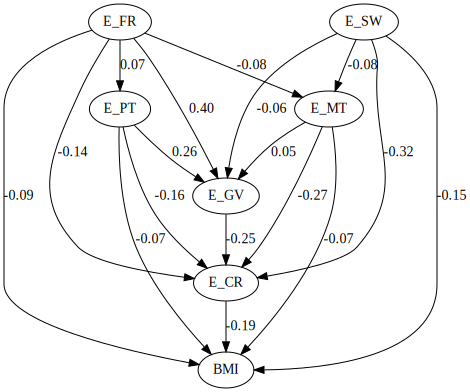

In [146]:
dot

In [145]:
causal_df.head(15)

,from,to,effect,probability
0,E_PT,E_CR,-0.237996,1.00
1,E_GV,E_CR,-0.253584,1.00
2,E_FR,E_CR,-0.245221,1.00
3,E_MT,E_CR,-0.277907,1.00
4,E_SW,E_CR,-0.293661,1.00
5,E_FR,E_GV,0.405026,1.00
6,E_SW,E_MT,-0.090678,0.94
7,E_PT,E_GV,0.275350,0.91
8,E_SW,BMI,-0.089900,0.91
9,E_FR,E_MT,-0.082357,0.67
